# Sumary:

* Below we finally predict labels (bag vs not-bag) for the train data.
* We use the autoencoder with dense neural-net trained in 'dimensionality_reduction.iynb',  with 'model1' trained in 'classification.ipynb'.
* The final precision and recall for the 'is-a-bag' class are both equal 97%.

In [1]:
from tensorflow import test
test.gpu_device_name()

'/device:GPU:0'

In [2]:
from google.colab import drive
drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [0]:
path = '/content/gdrive/My Drive/Colab Notebooks/Fashion_MNIST'

In [4]:
import os
from joblib import dump, load
from random import randint
import numpy as np
import matplotlib.pyplot as plt

from keras.datasets import fashion_mnist
from sklearn.model_selection import train_test_split
from sklearn.utils.class_weight import compute_class_weight

from keras.models import load_model
from keras.utils import to_categorical
import keras.backend as K
from keras.models import Sequential
from keras.layers import Dense, Conv2D, MaxPooling2D, Flatten, Dropout, BatchNormalization
from keras.optimizers import Adam
from keras.models import load_model

from sklearn.base import BaseEstimator, TransformerMixin
class GreyScale(BaseEstimator, TransformerMixin):
    def __init__(self):
        return None
      
    def fit(self, X, y=None):
        _, *self.img_dims = X.shape
        return self
        
    def transform(self, X):
        return X.reshape(-1, *self.img_dims, 1)
    
    def inverse_transform(self, X):
        return X.reshape(-1, *self.img_dims)

Using TensorFlow backend.


---
Start by loading the already decoded 20-dimensional images, and the labels. One has to make a copy of the y_test variable since it is 'read-only'.

In [0]:
(X_trainval, y_trainval), (X_test, y_test) = fashion_mnist.load_data()
X_train, X_val, y_train, y_val = train_test_split(X_trainval, y_trainval, test_size=0.1, random_state=42)

X20b_test = load(os.path.join(path,'X20b_test.joblib'))

greyscale = GreyScale()
greyscale.fit(X_train)
X20b_test = greyscale.transform(X20b_test)

y_test_01 = y_test.copy()
y_test_01[y_test_01 != 8] = 0
y_test_01[y_test_01 == 8] = 1
y_test_binary = to_categorical(y_test_01)

In [15]:
X20b_test.shape, y_test_binary.shape

((10000, 28, 28, 1), (10000, 2))

Load the model (a convolutional net as we recall).

In [0]:
model1 = load_model(os.path.join(path,'clf20_b.h5'))

Predict labels on the test X's.

In [17]:
y_test_pred = model1.predict(X20b_test)
y_test_pred_binary = np.round(y_test_pred)
y_test_pred_binary.shape

(10000, 2)

Print and visualize the scores. They are similar as for validation in the previous notebook.

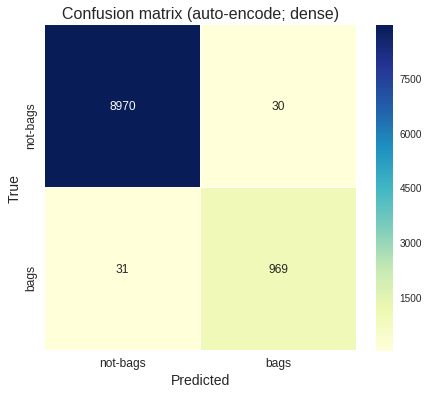

In [18]:
from sklearn.metrics import confusion_matrix
import seaborn as sns

cm = confusion_matrix(y_true=y_test_binary[:,1], y_pred=y_test_pred_binary[:,1])
fig, ax = plt.subplots()
fig.set_size_inches(7, 6)
sns.heatmap(cm, ax=ax, annot=True, fmt='d', cmap="YlGnBu",linewidths=.2)
ax.set_xlabel('Predicted', fontsize=14)
ax.set_ylabel('True', fontsize=14)
ax.set_xticklabels(['not-bags', 'bags'], fontsize=12)
ax.set_yticklabels(['bags', 'not-bags'], fontsize=12)
#plt.yticks(rotation=0)
plt.title('Confusion matrix (auto-encode; dense)', fontsize=16)
plt.show()

In [19]:
from sklearn.metrics import precision_score, recall_score, f1_score

print(f"Precision in the 'handbags'-class: {precision_score(y_test_binary[:,1], y_test_pred_binary[:,1])}")
print(f"Precision in the 'not-bags'-class: {precision_score(y_test_binary[:,0], y_test_pred_binary[:,0])}")
print(f"Micro-avg. precision of two classes: {precision_score(y_test_binary, y_test_pred_binary, average='micro')}")
print(f"Macro-avg. precision of two classes: {precision_score(y_test_binary, y_test_pred_binary, average='macro')}")
print("---")
print(f"Recall in the 'handbags'-class: {recall_score(y_test_binary[:,1], y_test_pred_binary[:,1])}")
print(f"Recall in the 'not-bags'-class: {recall_score(y_test_binary[:,0], y_test_pred_binary[:,0])}")
print(f"Micro-avg. recall of two classes: {recall_score(y_test_binary, y_test_pred_binary, average='micro')}")
print(f"Macro-avg. recall of two classes: {recall_score(y_test_binary, y_test_pred_binary, average='macro')}")
print("---")
print(f"F1 in the 'handbags'-class: {f1_score(y_test_binary[:,1], y_test_pred_binary[:,1])}")
print(f"F1 in the 'not-bags'-class: {f1_score(y_test_binary[:,0], y_test_pred_binary[:,0])}")
print(f"Micro-avg. f1 of two classes: {f1_score(y_test_binary, y_test_pred_binary, average='micro')}")
print(f"Macro-avg. f1 of two classes: {f1_score(y_test_binary, y_test_pred_binary, average='macro')}")

Precision in the 'handbags'-class: 0.96996996996997
Precision in the 'not-bags'-class: 0.9965559382290856
Micro-avg. precision of two classes: 0.9939
Macro-avg. precision of two classes: 0.9832629540995278
---
Recall in the 'handbags'-class: 0.969
Recall in the 'not-bags'-class: 0.9966666666666667
Micro-avg. recall of two classes: 0.9939
Macro-avg. recall of two classes: 0.9828333333333333
---
F1 in the 'handbags'-class: 0.9694847423711855
F1 in the 'not-bags'-class: 0.996611299372257
Micro-avg. f1 of two classes: 0.9939
Macro-avg. f1 of two classes: 0.9830480208717213


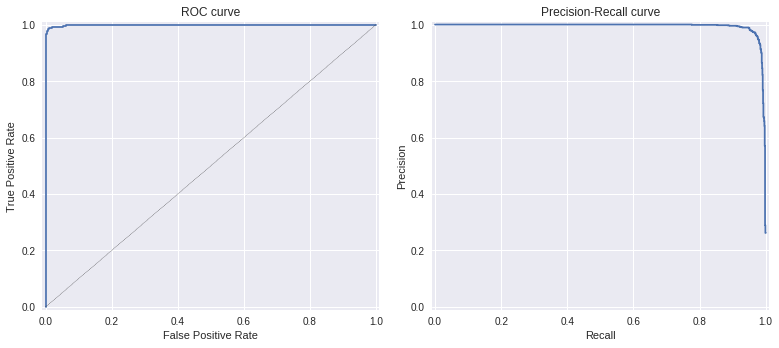

In [20]:
from sklearn.metrics import roc_curve, precision_recall_curve

fig, axes = plt.subplots(ncols=2)
fig.set_size_inches(11, 5)

ax = axes[0]

fpr, tpr, thresholds = roc_curve(y_test_binary[:,1], y_test_pred[:,1])
ax.plot(fpr, tpr)

ax.plot([0, 1], [0, 1], ls='--', color='black', lw=.3)
ax.set(xlabel='False Positive Rate',
       ylabel='True Positive Rate',
       xlim=[-.01, 1.01], ylim=[-.01, 1.01],
       title='ROC curve')
ax.grid(True)

ax = axes[1]

precision, recall, _ = precision_recall_curve(y_test_binary[:,1], y_test_pred[:,1])
ax.plot(recall, precision)
ax.set(xlabel='Recall', ylabel='Precision',
       xlim=[-.01, 1.01], ylim=[-.01, 1.01],
       title='Precision-Recall curve')
ax.grid(True)

plt.tight_layout()

Have a look at the missclassified images.

False positives: non-bags classified as bags.
Left: the original 28x28 image. Right: the image reproduced from 20-dim.


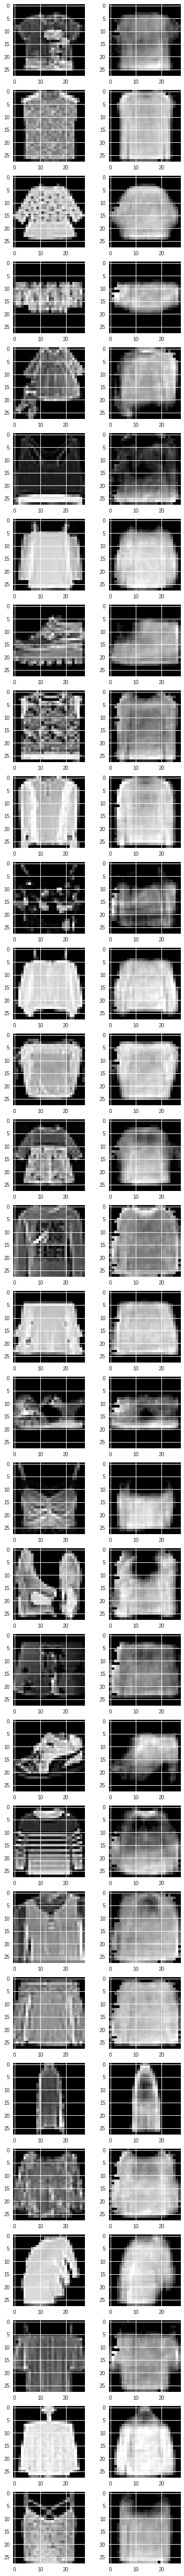

In [21]:
print(f"False positives: non-bags classified as bags.")
print("Left: the original 28x28 image. Right: the image reproduced from 20-dim.")
FP = (y_test_pred_binary[:,1] * y_test_binary[:,0]).astype('bool')
X_test_FP = greyscale.inverse_transform(X_test[FP])
X20_test_FP = greyscale.inverse_transform(X20b_test[FP])

size = 3
rows = np.sum(FP)
plt.figure(figsize=(size * 2, size * rows))

for i, img_pair in enumerate(zip(X_test_FP, X20_test_FP)):
  for j, img in enumerate(img_pair):
    plt.subplot(rows, 2, 2 * i + j + 1)
    plt.imshow(img, cmap='gray') 

False negatives: bags classified as not-bags.
Left: the original 28x28 image. Right: the image reproduced from 20-dim.


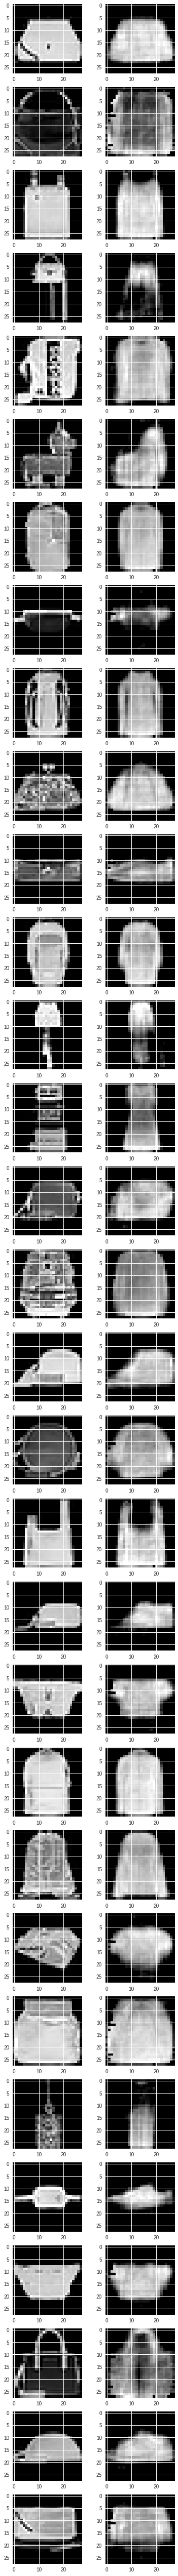

In [22]:
print(f"False negatives: bags classified as not-bags.")
print("Left: the original 28x28 image. Right: the image reproduced from 20-dim.")
FN = (y_test_pred_binary[:,0] * y_test_binary[:,1]).astype('bool')
X_test_FN = greyscale.inverse_transform(X_test[FN])
X20_test_FN = greyscale.inverse_transform(X20b_test[FN])

size = 3
rows = np.sum(FN)
plt.figure(figsize=(size * 2, size * rows))

for i, img_pair in enumerate(zip(X_test_FN, X20_test_FN)):
  for j, img in enumerate(img_pair):
    plt.subplot(rows, 2, 2 * i + j + 1)
    plt.imshow(img, cmap='gray') 

---
## End